# Friendship Sloop Detector Model

## Overview

This notebook demonstrates how to build and train a deep learning model to detect Friendship Sloops in images. The model is based on the ResNet50 architecture and uses data augmentation techniques to improve generalization. The notebook includes steps for data preprocessing, model definition, training, and evaluation.

## Prerequisites
Before running this notebook, ensure you have the following prerequisites:

- Python 3.6 or higher
- TensorFlow 2.x
- Keras
- OpenCV
- Matplotlib
- dotenv
- scipy

## Setup Instructions

### 1. Clone the Repository: 

Clone the repository containing this notebook and navigate to the directory.
Be sure to create the virtual environment.

```bash
git clone <repository_url>
cd <repository_directory>

python3 -m venv venv
source venv/bin/activate
``` 

### 2. Install Dependencies:

Install the required Python packages using pip.

```bash
pip install --upgrade pip
pip install -r requirements.txt
```

### 3. Set Up Environment Variables:

Create a `.env` file in the root directory and define the following environment variables:

```bash
DATA_DIR=path/to/your/data
BATCH_SIZE=32
NUM_EPOCHS=10
MODEL_PATH=path/to/save/model
```

Going forward, use the notebook service that best suits your needs to run this notebook.

## 1. Import Libraries

Imports the necessary libraries for data preprocessing, model building, with metrics and environment management.

In [1]:
from random import randrange
import random
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
import cv2
import os
import pprint
from pathlib import Path
from dotenv import load_dotenv

# Suppress only the single warning from urllib3.
import urllib3
urllib3.disable_warnings(category=urllib3.exceptions.InsecureRequestWarning)

# Load environment variables from the .env file (if present)
load_dotenv()

# Define the config class
class CFG:

    # Define the directory to store the images
    DATA_DIR = Path(os.environ['DATA_DIR'])
    
    # Set the number of batchs for processing
    BATCH_SIZE = int(os.environ['BATCH_SIZE'])

    # Epocs for model training
    NUM_EPOCHS = int(os.environ['NUM_EPOCHS'])
    
    # Where to save the generated model
    MODEL_PATH = Path(os.environ['MODEL_PATH'])
    
    # Default image size for the model
    IMAGE_SIZE = int(os.environ['IMAGE_SIZE'])
    
    # Generate a random number for the seed
    SEED = randrange(1000)
    
pprint.pprint(CFG.__dict__)

2024-11-12 14:20:34.561592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


mappingproxy({'BATCH_SIZE': 32,
              'DATA_DIR': PosixPath('data'),
              'IMAGE_SIZE': 256,
              'MODEL_PATH': PosixPath('saved_model/friendship_sloop_detector.keras'),
              'NUM_EPOCHS': 10,
              'SEED': 519,
              '__dict__': <attribute '__dict__' of 'CFG' objects>,
              '__doc__': None,
              '__module__': '__main__',
              '__weakref__': <attribute '__weakref__' of 'CFG' objects>})


## 2. Display Random Image Set

Displays a random sample of images from `{CFG.DATA_DIR}/train/` in a 3x3 grid.

<Figure size 1000x500 with 0 Axes>

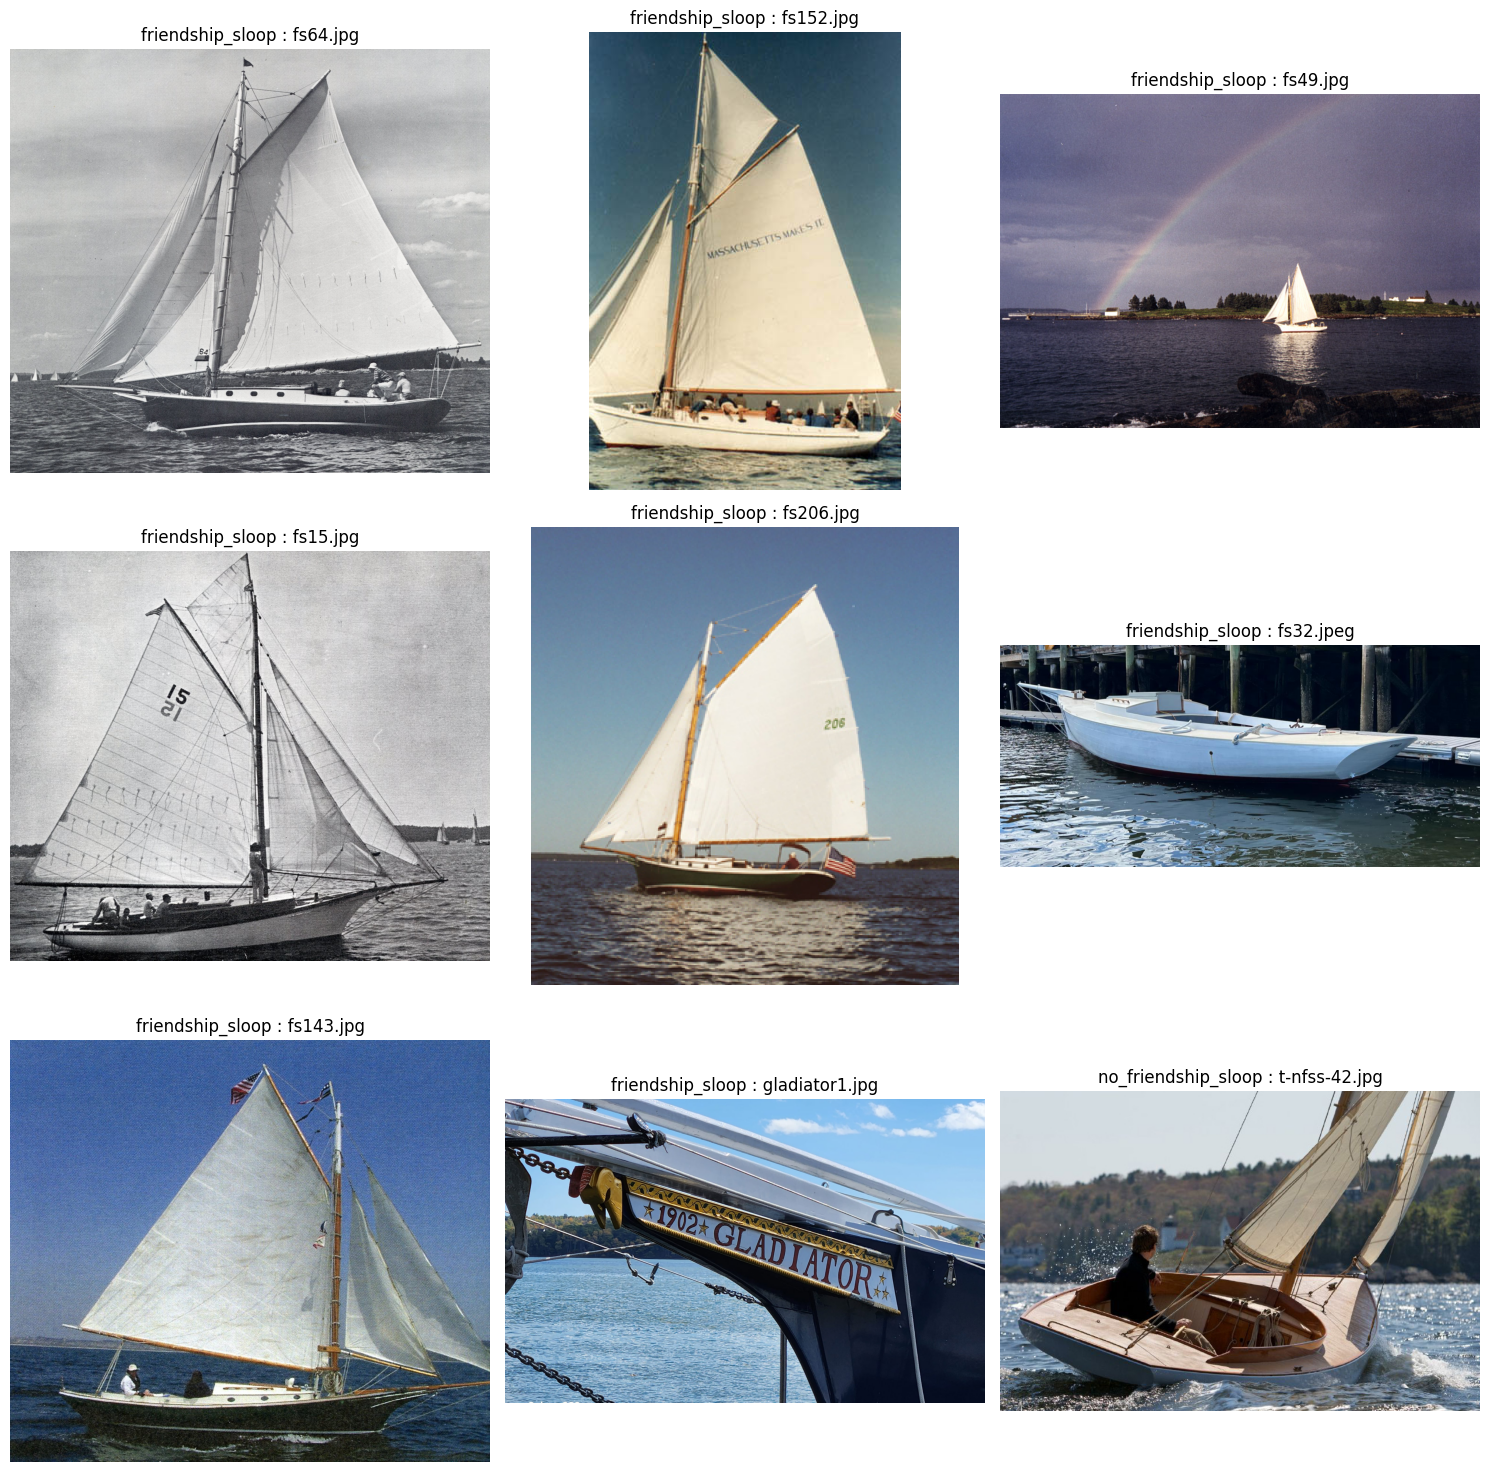

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from PIL import Image  # Import Image from PIL

# Define the source path
src_path = f"{CFG.DATA_DIR}/train/"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
path = os.path.join(src_path,sub_class[0])

# List all files in the directory
all_files = []
for subdir, _, files in os.walk(src_path):
    for file in files:
        all_files.append(os.path.join(subdir, file))

# Select 9 random files
random_files = random.sample(all_files, 9)

# Display the selected files
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for img_path, ax in zip(random_files, axes):
    img = Image.open(img_path)
    pth = str(Path(img_path).parent).replace(str(src_path), '')
    ax.imshow(img)
    ax.axis('off')
    ax.set_title( f'{pth} : {os.path.basename(img_path)}')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Configures the data augmentation and preprocessing using ImageDataGenerator. 

It defines training, validation and test data generators that load images from the specified directory and apply transformations.


In [16]:
# Path to the training data
src_path_train = f"{CFG.DATA_DIR}/train/"
# Path to the test data
src_path_test = f"{CFG.DATA_DIR}/test/"

# Build the training and test data generators
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20
)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

print(f'Procesing training data from: {src_path_train}')
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size= (CFG.IMAGE_SIZE, CFG.IMAGE_SIZE), # target_size,
    color_mode="rgb",
    batch_size=CFG.BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
print(f'{len(train_generator.filenames)} : {sorted(train_generator.filenames)}')
print('-' * 50)

print(f'Procesing validation data from: {src_path_train}')
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size= (CFG.IMAGE_SIZE, CFG.IMAGE_SIZE), # target_size,
    color_mode="rgb",
    batch_size=CFG.BATCH_SIZE,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
print(f'{len(valid_generator.filenames)} : {valid_generator.filenames}')
print('-' * 50)

print(f'Procesing test data from: {src_path_test}')
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size= (CFG.IMAGE_SIZE, CFG.IMAGE_SIZE), # target_size,
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)
print(f'{len(test_generator.filenames)} : {test_generator.filenames}')


Procesing training data from: data/train/
Found 232 images belonging to 2 classes.
232 : ['friendship_sloop/fs13a.jpg', 'friendship_sloop/fs14.jpg', 'friendship_sloop/fs141.jpg', 'friendship_sloop/fs142.jpg', 'friendship_sloop/fs143.jpg', 'friendship_sloop/fs144.jpg', 'friendship_sloop/fs144a.jpg', 'friendship_sloop/fs145.jpg', 'friendship_sloop/fs146.jpg', 'friendship_sloop/fs147b.jpeg', 'friendship_sloop/fs15.jpg', 'friendship_sloop/fs152.jpg', 'friendship_sloop/fs155.jpeg', 'friendship_sloop/fs155a.jpg', 'friendship_sloop/fs157a.jpg', 'friendship_sloop/fs159.jpg', 'friendship_sloop/fs16.jpg', 'friendship_sloop/fs164.jpg', 'friendship_sloop/fs167.jpeg', 'friendship_sloop/fs169.jpg', 'friendship_sloop/fs17.jpg', 'friendship_sloop/fs171.jpg', 'friendship_sloop/fs172.jpg', 'friendship_sloop/fs175.jpg', 'friendship_sloop/fs177.jpg', 'friendship_sloop/fs178.jpg', 'friendship_sloop/fs18.jpg', 'friendship_sloop/fs180.jpeg', 'friendship_sloop/fs180a.jpg', 'friendship_sloop/fs183.jpg', 'frien

## 4. Filesystem accounting

Code block to find the number of files in the given directory to compare against the loaded image values from above.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class indices
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f'Class names: {class_names}')
print('-' * 50)

# Count the number of instances for each class in the training set
train_counts = np.bincount(train_generator.classes)
val_counts = np.bincount(valid_generator.classes)
test_counts = np.bincount(test_generator.classes)

# Print the counts for each class
print(f"Training set class distribution: {dict(zip(class_names, train_counts))}")
print(f"Validation set class distribution: {dict(zip(class_names, val_counts))}")
print(f"Test set class distribution: {dict(zip(class_names, test_counts))}")
print('-' * 50)

# Verify file counts on the filesystem
def count_files_in_directory(directory):
    file_counts = {}
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            file_counts[dir_name] = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
    return file_counts

train_file_counts = count_files_in_directory(src_path_train)
test_file_counts = count_files_in_directory(src_path_test)

print(f"Filesystem training set class distribution: {train_file_counts}")
print(f"Filesystem test set class distribution: {test_file_counts}")

# Ensure the counts arrays are the same length as the number of classes
if len(train_counts) < len(class_names):
    train_counts = np.append(train_counts, [0] * (len(class_names) - len(train_counts)))
if len(val_counts) < len(class_names):
    val_counts = np.append(val_counts, [0] * (len(class_names) - len(val_counts)))
if len(test_counts) < len(class_names):
    test_counts = np.append(test_counts, [0] * (len(class_names) - len(test_counts)))

# Plot the class distribution for the training, validation, and test sets
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(class_names))

plt.bar(index, train_counts, bar_width, color='blue', alpha=0.7, label='Training Set')
plt.bar(index + bar_width, val_counts, bar_width, color='green', alpha=0.7, label='Validation Set')
plt.bar(index + 2 * bar_width, test_counts, bar_width, color='red', alpha=0.7, label='Test Set')

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(index + bar_width, class_names)
plt.legend()
plt.show()

## 5. Model Definition

This section defines the model architecture using the ResNet50 base model with custom classification layers. The base model's layers are frozen to prevent them from being trained and adds multiple metrics.

In [5]:
# Load ResNet50 with pretrained weights and exclude top layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(CFG.IMAGE_SIZE, CFG.IMAGE_SIZE, 3)
)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
print(f'Made: {x}')

# Final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with additional metrics
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Precision(), Recall()]
)

model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=CFG.NUM_EPOCHS
)

Made: <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_177>


/Users/dennis/Documents/Projects/isitafriendship/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8483 - loss: 0.5730 - precision: 0.8483 - recall: 0.8483

/Users/dennis/Documents/Projects/isitafriendship/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8410 - loss: 0.5836 - precision: 0.8410 - recall: 0.8410 - val_accuracy: 0.7857 - val_loss: 0.5378 - val_precision: 0.7857 - val_recall: 0.7857
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7695 - loss: 0.5728 - precision: 0.7695 - recall: 0.7695 - val_accuracy: 0.7857 - val_loss: 0.5216 - val_precision: 0.7857 - val_recall: 0.7857
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7974 - loss: 0.5127 - precision: 0.7974 - recall: 0.7974 - val_accuracy: 0.7857 - val_loss: 0.5155 - val_precision: 0.7857 - val_recall: 0.7857
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7621 - loss: 0.5285 - precision: 0.7621 - recall: 0.7621 - val_accuracy: 0.7857 - val_loss: 0.5115 - val_precision: 0.7857 - val_recall: 0.7857
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7687 - loss: 0.5105 - precision: 0.7687 - recall: 0.7687 - val_accuracy: 0.7857 - val_loss: 0.5006 - val_precision: 0.7857 - 

## 6. Evaluate and the Model

This section evaluates the model's performance on the `validation` dataset, then graphicly displays in information.

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7961 - loss: 0.5294 - precision: 0.7961 - recall: 0.7961
   Accuracy  Precision    Recall      Loss
0  0.803571   0.803571  0.803571  0.529249


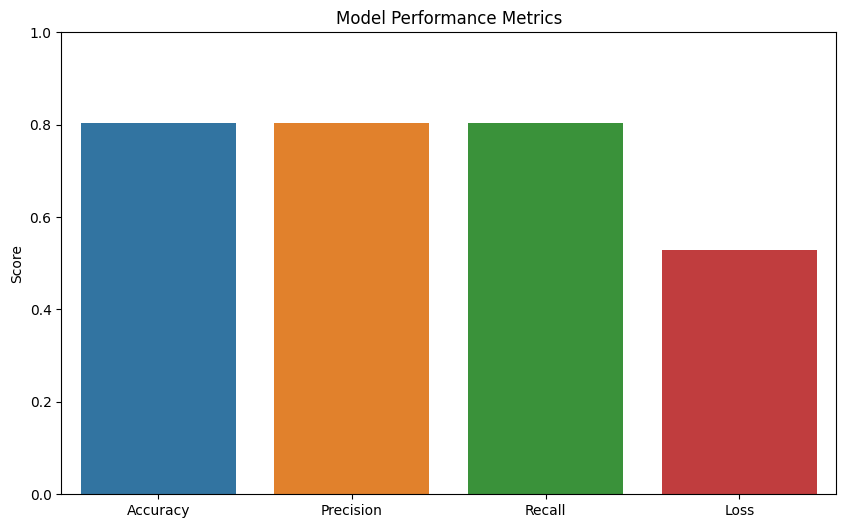

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import HTML, display

# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(valid_generator)

# Create the metrics object
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'Loss': loss
}

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics, index=[0])

# Display metrics as a table
print(metrics_df)

# Plot metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Function to generate HTML explanation
def generate_explanation_html(metrics):
    explanation_html = f"""
    <h3>Explanation of Metrics</h3>
    <ol>
        <li><strong>Accuracy</strong>:
            <ul>
                <li><strong>Definition</strong>: The proportion of correctly classified instances out of the total instances.</li>
                <li><strong>Good Value</strong>: Generally, an accuracy above 0.80 (80%) is considered good, but this can vary depending on the complexity of the task and the dataset.</li>
                <li><strong>Current Value</strong>: {metrics['Accuracy']:.2f}</li>
            </ul>
        </li>
        <li><strong>Precision</strong>:
            <ul>
                <li><strong>Definition</strong>: The proportion of true positive predictions out of all positive predictions (i.e., the accuracy of positive predictions).</li>
                <li><strong>Good Value</strong>: A precision above 0.75 (75%) is typically considered good. High precision indicates that the model has a low false positive rate.</li>
                <li><strong>Current Value</strong>: {metrics['Precision']:.2f}</li>
            </ul>
        </li>
        <li><strong>Recall</strong>:
            <ul>
                <li><strong>Definition</strong>: The proportion of true positive predictions out of all actual positives (i.e., the ability of the model to find all relevant instances).</li>
                <li><strong>Good Value</strong>: A recall above 0.75 (75%) is generally considered good. High recall indicates that the model has a low false negative rate.</li>
                <li><strong>Current Value</strong>: {metrics['Recall']:.2f}</li>
            </ul>
        </li>
        <li><strong>Loss</strong>:
            <ul>
                <li><strong>Definition</strong>: A measure of how well the model's predictions match the actual labels. Lower loss values indicate better performance.</li>
                <li><strong>Good Value</strong>: The acceptable loss value depends on the specific loss function used and the problem context. Generally, lower values are better.</li>
                <li><strong>Current Value</strong>: {metrics['Loss']:.2f}</li>
            </ul>
        </li>
    </ol>
    """
    return explanation_html

# Generate and display the explanation using HTML
explanation_html = generate_explanation_html(metrics)
display(HTML(explanation_html))

## 7. Save the model

Saves the model to the `CFG.MODEL_PATH` in the `keras` file format, aka and compressed file with the model contained with in.

In [7]:
# Create the base directory if it doesn't exist
base_dir = CFG.MODEL_PATH.parent
os.makedirs(base_dir, exist_ok=True)

# Save model
model.save(CFG.MODEL_PATH)
print(f'saved { os.path.getsize(CFG.MODEL_PATH) } bytes to {CFG.MODEL_PATH}')

saved 98157169 bytes to saved_model/friendship_sloop_detector.keras


## 8. Model Testing on New Images

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (CFG.IMAGE_SIZE, CFG.IMAGE_SIZE))
    img = img / 255.0
    img = img.reshape(-1, CFG.IMAGE_SIZE, CFG.IMAGE_SIZE, 3)
    return img

# Predict
# Directory containing test images
test_image_dir = 'images/prediction'

# Iterate over all images in the directory
for filename in os.listdir(test_image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        test_image_path = os.path.join(test_image_dir, filename)
        
        # Show the test image
        plt.imshow(Image.open(test_image_path))
        plt.axis('off')
        plt.show()

        # Preprocess and predict
        img = preprocess_image(test_image_path)
        prediction = model.predict(img)

        print(f"Prediction for {filename}: {prediction}")
        if prediction[0][0] > 0.5:
            print("Friendship Sloop detected")
        else:
            print("No Friendship Sloop detected")


## Appendix

Block of code below wil ensure the images are in a valid format. If not, it will convert tot he mode to RGB and save the `target_format`

In [ ]:
import os
from PIL import Image

def verify_and_convert_images(directory, target_format='JPEG'):
    jpg_count = 0
    other_count = 0
    error_count = 0
    
    supported_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.ppm', '.tif', '.tiff']
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_ext = os.path.splitext(file)[1].lower()
            
            if file_ext not in supported_extensions:
                print(f"Unsupported file extension: {file_path}")
                continue
            try:

                with Image.open(file_path) as img:
                    img.verify()  # Verify that it is a valid image
                    img.close()
    
                with Image.open(file_path) as img:
                    if img.format != target_format:
                        
                        print(f"Processing {other_count} {file_path}")
                        other_count += 1
                        print(img.format, img.size, img.mode)
                        
                        try:
                            # Convert to target format if necessary
                            img = img.convert('RGB')
                            new_file_path = os.path.splitext(file_path)[0] + f'.{target_format.lower()}'
                            print(f"Converted {file_path} to {new_file_path}")
                            
                            img.save(new_file_path, target_format)
                            print(f'Saved {os.path.getsize(new_file_path)} bytes to {new_file_path}')
                            
                            os.remove(file_path)
                            print(f"Removed {file_path}")
                            print('-' * 40)

                        except Exception as e:
                            print(f"Error {error_count} converting {file_path}: {e}")
                            error_count += 1
                            pass

                    else:
                        # print(f"Verified {file_path}")
                        jpg_count += 1

            except (IOError, SyntaxError) as e:
                print(f"Corrupted or unsupported image file: {file_path} - {e}")

    print(f"{target_format}: {jpg_count} | other: {other_count} | error: {error_count} | total files: {jpg_count + other_count}")

# Verify and convert images in the training and validation directories
verify_and_convert_images('data/train')
verify_and_convert_images('data/test')